## Regress out cell counts from all features on a subset

In [1]:
import sys

sys.path.append("../1.load")

import numpy as np
import pandas as pd

from preprocess import preprocess_profiles, config
from correct_position_effect import (
    subtract_well_mean,
    mad_robustize_col,
    regress_out_cell_counts,
)

import seaborn as sns
from matplotlib import pyplot as plt

#### Load a subset of profiles

In [2]:
CC_COL = "Cells_Count"

In [3]:
ann_profiles = pd.read_parquet("../1.load/output/subset_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,48.712002,46.077000,46.318001,46.028999,46.393002,46.639000,47.831001,46.651001,48.021000,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,61.765999,57.683998,58.122002,57.683998,58.137001,58.535999,60.215000,58.625999,60.560001,2021_08_09_Batch11
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,42.872002,40.491001,40.872002,40.462002,40.923000,41.264000,42.422001,41.236000,42.514000,2021_08_09_Batch11
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,51.533001,49.242001,49.653000,49.251999,49.708000,50.063999,51.639999,50.113998,51.570000,2021_08_09_Batch11
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,55.993000,52.728001,53.193001,52.875999,53.160000,53.438000,54.987999,53.695000,55.131001,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,31.225000,28.951000,29.181999,29.153999,29.162001,29.171000,30.061001,29.388000,29.938000,2021_05_17_Batch4
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,34.605999,32.294998,32.636002,32.362000,32.466000,32.683998,33.604000,32.743999,33.476002,2021_05_17_Batch4
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,30.981001,28.872999,29.042000,28.905001,29.143999,29.282000,30.084999,29.292000,30.077000,2021_05_17_Batch4
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,33.861000,31.473000,31.583000,31.374001,31.563999,31.844000,32.480000,31.665001,32.480999,2021_05_17_Batch4


Text(0.05986522488638144, 5, '0.060')

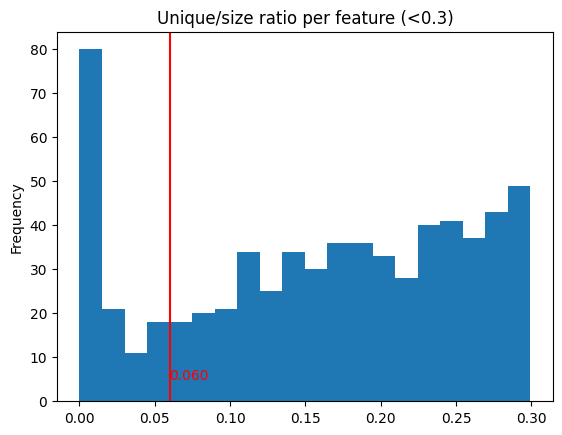

In [4]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio < 0.3].plot(
    kind="hist", bins=20, title="Unique/size ratio per feature (<0.3)"
)
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(
    unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red"
)

#### Explore correlations with cell counts

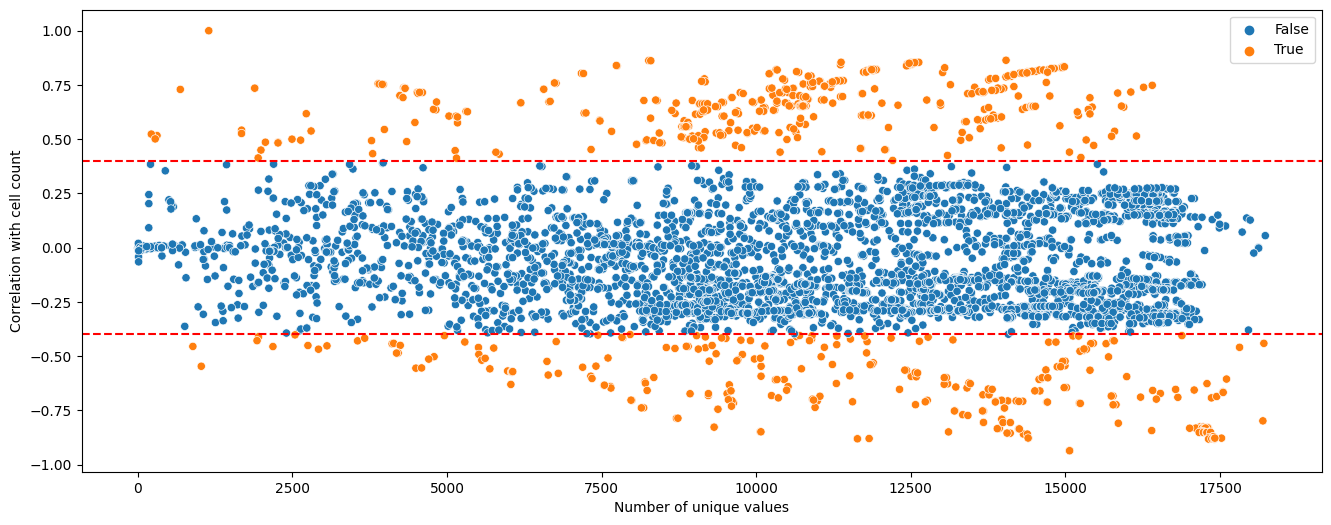

In [5]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)")
    .corrwith(ann_profiles["Cells_Count"])
    .abs()
    > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")


plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### List low unique ratio features that are correlated with cell count

No features that have nigh correlations and less than 1000 unique values

In [6]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_profiles[
        feature
    ].nunique() < 1000:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cytoplasm_RadialDistribution_MeanFrac_AGP_3of4: -0.4552927188489635
Image_Threshold_SumOfEntropies_CellsIncludingEdges: 0.7294399617871812
Nuclei_Correlation_Manders_AGP_RNA: 0.5167498882104065
Nuclei_Correlation_Manders_ER_RNA: 0.5234919265759052
Nuclei_Correlation_Manders_Mito_RNA: 0.5013310413956075


#### Histogram of unique values for feature columns with less than 100 unique values

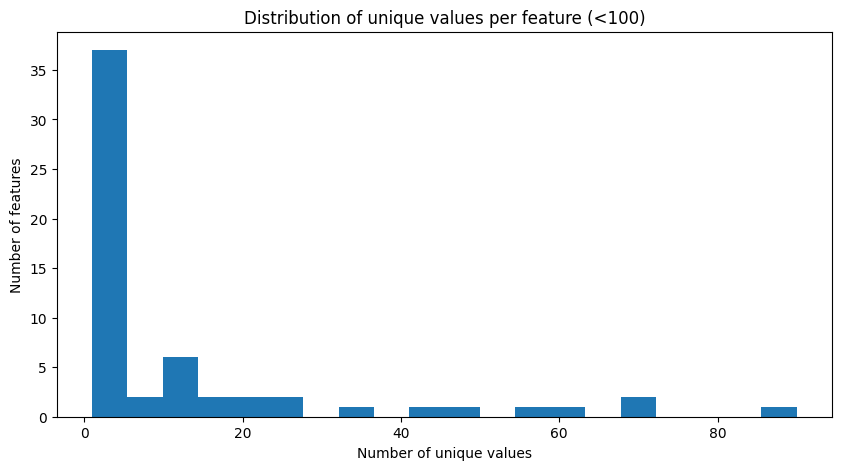

In [7]:
num_unique = ann_profiles.filter(regex="^(?!Metadata_)").nunique()

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(num_unique[num_unique < 100], bins=20)
ax.set_xlabel("Number of unique values")
ax.set_ylabel("Number of features")
ax.set_title("Distribution of unique values per feature (<100)")
plt.show()

In [8]:
# get features with low number of unique values
low_unique_features = num_unique[num_unique < 2].index.to_list()
len(low_unique_features)

34

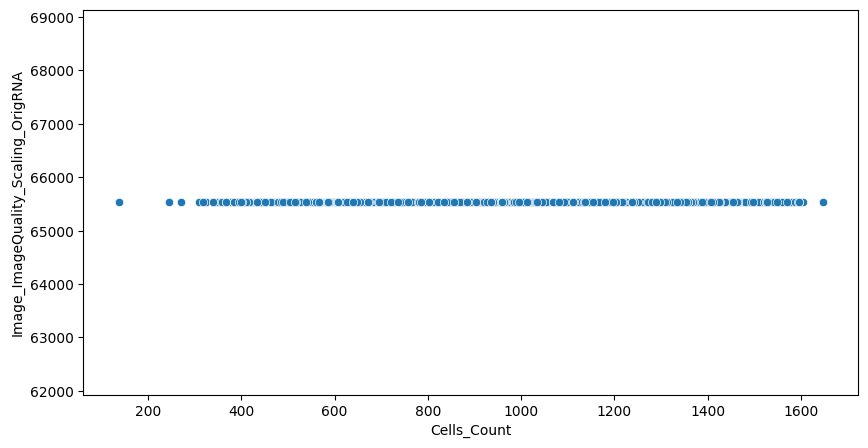

In [9]:
# plot correlation between cell count and a one unique feature
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=ann_profiles,
    x="Cells_Count",
    y=ann_profiles["Image_ImageQuality_Scaling_OrigRNA"],
)
plt.show()

### Regress out cell count from all features, including low unique count ones

In [10]:
ann_profiles_lowu = regress_out_cell_counts(
    ann_profiles, CC_COL, min_unique=0, inplace=False
)
ann_profiles_lowu

  0%|          | 0/4762 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-21.558212,-20.349036,-20.629806,-20.368307,-20.650465,-20.884252,-21.519006,-20.845826,-21.408608,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-5.083011,-5.481468,-5.539859,-5.454783,-5.611743,-5.671016,-5.737693,-5.557698,-5.461906,2021_08_09_Batch11
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-27.798565,-26.316590,-26.460330,-26.316621,-26.506019,-26.647322,-27.325564,-26.648534,-27.314382,2021_08_09_Batch11
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-16.225903,-14.790638,-14.882782,-14.753411,-14.917000,-15.024994,-15.216235,-14.950850,-15.358211,2021_08_09_Batch11
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-17.152480,-16.438301,-16.516399,-16.259854,-16.652436,-16.872302,-17.217198,-16.586266,-17.162526,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-43.267124,-41.498717,-41.820804,-41.264465,-41.947294,-42.444629,-43.481436,-42.197370,-43.696856,2021_05_17_Batch4
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-33.771634,-32.327318,-32.494047,-32.232718,-32.754854,-33.004740,-33.866642,-32.920032,-34.068495,2021_05_17_Batch4
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-39.180025,-37.448975,-37.800936,-37.388310,-37.794317,-38.135415,-39.156583,-38.099089,-39.243852,2021_05_17_Batch4
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-35.390131,-33.981802,-34.386014,-34.052681,-34.498060,-34.691437,-35.858042,-34.844936,-35.933549,2021_05_17_Batch4


In [11]:
for feature in ann_profiles_lowu.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles_lowu["Cells_Count"].corr(ann_profiles_lowu[feature])
    if feature_corr > 0.5:
        print(
            f"{feature}: {ann_profiles_lowu.Cells_Count.corr(ann_profiles_lowu[feature])}"
        )

Cells_Count: 1.0


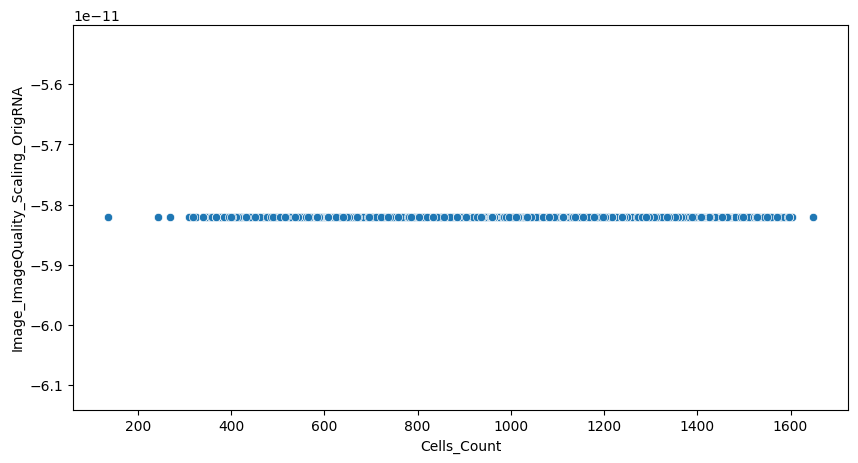

In [12]:
# plot correlation between cell count and a first low unique feature
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=ann_profiles_lowu,
    x="Cells_Count",
    y=ann_profiles_lowu["Image_ImageQuality_Scaling_OrigRNA"],
)
plt.show()

#### Now, regress out cell counts only from features that have >100 unique values

In [13]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL, min_unique=100)
ann_profiles

  0%|          | 0/4703 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-21.558212,-20.349036,-20.629806,-20.368307,-20.650465,-20.884252,-21.519006,-20.845826,-21.408608,2021_08_09_Batch11
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-5.083011,-5.481468,-5.539859,-5.454783,-5.611743,-5.671016,-5.737693,-5.557698,-5.461906,2021_08_09_Batch11
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-27.798565,-26.316590,-26.460330,-26.316621,-26.506019,-26.647322,-27.325564,-26.648534,-27.314382,2021_08_09_Batch11
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-16.225903,-14.790638,-14.882782,-14.753411,-14.917000,-15.024994,-15.216235,-14.950850,-15.358211,2021_08_09_Batch11
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-17.152480,-16.438301,-16.516399,-16.259854,-16.652436,-16.872302,-17.217198,-16.586266,-17.162526,2021_08_09_Batch11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-43.267124,-41.498717,-41.820804,-41.264465,-41.947294,-42.444629,-43.481436,-42.197370,-43.696856,2021_05_17_Batch4
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-33.771634,-32.327318,-32.494047,-32.232718,-32.754854,-33.004740,-33.866642,-32.920032,-34.068495,2021_05_17_Batch4
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-39.180025,-37.448975,-37.800936,-37.388310,-37.794317,-38.135415,-39.156583,-38.099089,-39.243852,2021_05_17_Batch4
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-35.390131,-33.981802,-34.386014,-34.052681,-34.498060,-34.691437,-35.858042,-34.844936,-35.933549,2021_05_17_Batch4


#### Check if cell count has correlation above 0.5 with any feature

In [14]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if np.abs(feature_corr) > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cells_Count: 1.0


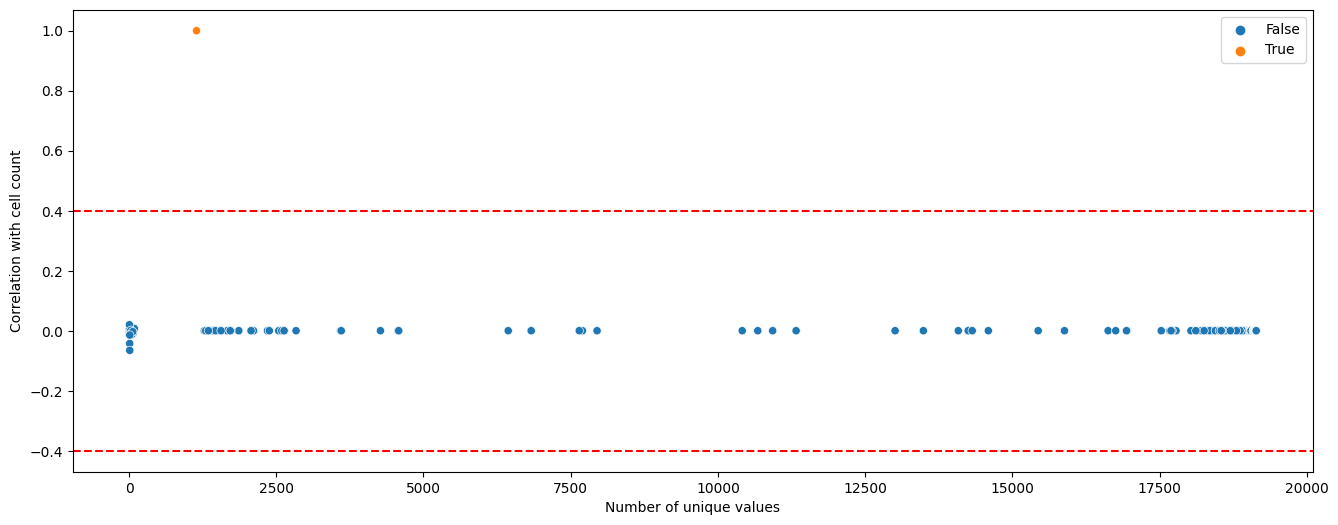

In [15]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6))
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)")
    .corrwith(ann_profiles["Cells_Count"])
    .abs()
    > corr_cutoff,
)
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")


plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Plot the ratio of unique values / size for cell count

This is the reason it gets filtered by `feature_select`

Text(0.05986522488638144, 5, '0.060')

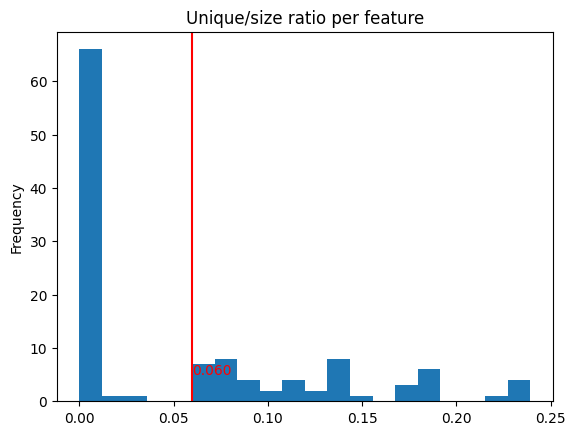

In [16]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio < 0.3].plot(
    kind="hist", bins=20, title="Unique/size ratio per feature"
)
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(
    unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red"
)

#### Preprocess and save CC-corrected subset

In [17]:
ann_profiles_processed = preprocess_profiles(ann_profiles)
ann_profiles_processed

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.843619,0.076587,0.320472,-0.385526,0.190299,0.455335,0.509991,-1.019452,-0.727796,-0.842709
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.553261,-1.089581,-0.339225,-1.516519,-0.441941,-0.130427,-0.575876,0.593761,0.509689,-0.214481
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.234735,-0.754526,0.077711,-0.321833,0.405425,0.628227,0.367096,0.264792,-0.726009,-0.754048
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.015636,-0.494281,-0.287685,-0.627869,-0.710446,-0.636987,-0.199217,-0.135424,-0.290031,0.329685
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.037931,-0.722416,-0.448440,-1.166354,-1.939870,-1.752882,-0.387810,-0.074516,0.047316,1.303088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.711810,-3.969504,-0.809101,-2.974631,-2.787255,-0.704379,0.198949,2.074013,0.223548,-0.531547
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.077549,-3.094378,-0.711043,-2.103474,-1.919203,-0.485693,0.300183,1.795833,-0.029274,-0.503630
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.488542,-3.648642,-0.653825,-2.628841,-2.837851,-0.915129,0.115583,2.372840,0.351046,0.082553
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.968013,-4.203432,-0.806062,-2.797244,-2.399043,-0.965500,0.605841,2.384713,0.194849,0.017739


In [18]:
# check that the cell count column is still there
assert CC_COL in ann_profiles_processed.columns

ann_profiles_processed.to_parquet(
    "output/subset_profiles_cc_corrected.parquet", index=False
)
del ann_profiles_processed

#### Apply well mean subtraction, preprocess and save

In [19]:
ann_profiles = subtract_well_mean(ann_profiles)
ann_profiles = preprocess_profiles(ann_profiles)
ann_profiles.to_parquet("output/subset_profiles_cc_well_corrected.parquet", index=False)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_SumVariance_AGP_5_01_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.741697,0.112122,0.722847,-0.542750,0.445720,0.554508,0.000264,-0.777772,-0.271738,-0.301078
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.343989,-0.859932,-0.216329,-1.635583,-0.594059,-0.245754,-0.384134,0.320276,0.534325,-0.265633
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.051992,-0.284848,0.654815,-0.384974,0.738728,0.778361,0.157445,0.227226,-0.378582,-0.490790
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.024693,-0.186849,-0.008604,-0.695158,-0.444212,-0.445083,-0.123787,-0.066532,-0.135855,-0.355348
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.032271,-0.443314,0.015008,-1.215016,-1.526007,-1.410647,-0.958586,-0.033967,0.286181,-0.107765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.496163,-3.650756,-0.848449,-2.936727,-2.436284,-0.436749,0.461949,2.106643,0.340530,-0.859631
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.888448,-2.750166,-0.259634,-2.186029,-1.711072,-0.143175,0.290318,1.652127,-0.077727,-0.304504
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.663130,-3.759996,-0.894969,-2.654908,-3.027197,-1.034693,0.780943,2.484684,0.176172,-0.159027
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.470541,-4.788110,-1.018985,-3.183447,-3.002070,-1.291024,1.253810,2.806402,0.129072,-0.161529


#### Regress out cell count from the preprocessed subset

In [20]:
ann_profiles = pd.read_parquet("../1.load/output/subset_processed_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.128693,0.473757,-0.347879,0.571560,0.233940,0.605959,0.578546,-1.185371,-0.876162,-1.057080
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.980136,-0.033563,-1.433294,-0.133203,-0.359655,0.173131,-0.434340,0.301357,0.198563,-0.642012
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.702068,0.221388,-0.288633,0.636346,0.443830,0.758651,0.430319,0.111360,-0.859052,-0.949096
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.402167,-0.019364,-0.564355,0.445624,-0.636230,-0.359488,-0.078135,-0.393716,-0.545916,-0.065805
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.705514,-0.389203,-1.144660,-0.064180,-1.915246,-1.671197,-0.359077,-0.137749,-0.010367,1.175190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.948126,-0.793898,-2.941786,-1.063806,-2.772297,-0.700941,0.197062,2.056191,0.213081,-0.520526
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.992120,-0.456330,-2.026512,-0.405664,-1.845284,-0.236853,0.404465,1.556922,-0.268032,-0.835626
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.567792,-0.471175,-2.561244,-0.951795,-2.777763,-0.729796,0.190742,2.197634,0.171086,-0.169995
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.105547,-0.583482,-2.719235,-1.129802,-2.331747,-0.741819,0.691152,2.176523,-0.016072,-0.283463


In [21]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL)
ann_profiles

  0%|          | 0/596 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.185587,0.380554,-0.338434,0.434017,0.316296,0.449249,0.467342,-0.806714,-0.419014,-0.599806
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.972070,-0.262187,-1.454826,-0.374529,-0.312747,-0.123587,-0.605621,0.803963,0.787039,0.006647
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.639460,0.144033,-0.275563,0.510948,0.530334,0.618325,0.326145,0.475512,-0.417272,-0.514218
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.381114,-0.211971,-0.577648,0.231900,-0.579894,-0.618970,-0.233438,0.075924,0.007632,0.531954
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.607584,-0.368595,-1.109182,-0.114502,-1.803099,-1.710241,-0.419790,0.136737,0.336410,1.471619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.830976,-0.719985,-2.894114,-1.073277,-2.646198,-0.684874,0.159997,2.281889,0.508166,-0.299429
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.962237,-0.624447,-2.034203,-0.600618,-1.782537,-0.471014,0.260027,2.004147,0.261765,-0.272479
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.512456,-0.568700,-2.552787,-1.092650,-2.696538,-0.890974,0.077621,2.580246,0.632425,0.293387
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.063197,-0.717024,-2.719017,-1.298260,-2.259950,-0.940233,0.562053,2.592100,0.480195,0.230819


In [22]:
ann_profiles[CC_COL] = mad_robustize_col(
    ann_profiles[CC_COL], epsilon=config["MAD_EPSILON"]
)

In [23]:
ann_profiles.to_parquet("output/subset_processed_cc_corrected.parquet", index=False)

#### Regress out cell count from the preprocessed and corrected dataset

In [24]:
ann_profiles = pd.read_parquet(
    "output/subset_profiles_mean_corrected_preprocessed.parquet"
)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.797964,0.146889,0.819626,-0.509162,0.472246,0.642571,0.066639,-0.881828,-0.350346,-1.073462
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.008865,-0.727388,0.174203,-1.533879,-0.491494,0.133758,-0.166958,-0.046317,0.143711,-0.708113
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,0.092513,-0.227106,0.816801,-0.338477,0.779462,0.923069,0.256522,0.053473,-0.516544,-1.248105
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.276741,-0.083435,0.298098,-0.617487,-0.362693,-0.138579,0.048441,-0.356336,-0.417139,-0.335329
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,0.041956,-0.413953,0.105639,-1.180939,-1.491780,-1.289569,-0.893923,-0.129758,0.202304,0.657390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.129169,-3.538052,-0.520986,-2.842335,-2.340782,-0.125134,0.631924,1.785901,0.033014,-0.950628
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.647335,-2.680459,-0.061623,-2.122819,-1.649972,0.044671,0.398540,1.443853,-0.248181,-1.030151
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.226561,-3.621300,-0.492199,-2.546169,-2.909262,-0.634581,0.987791,2.092285,-0.198693,-0.264711
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.100456,-4.689352,-0.735747,-3.097704,-2.914871,-1.003231,1.391593,2.519940,-0.121851,-0.152886


In [25]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL)
ann_profiles

  0%|          | 0/626 [00:00<?, ?it/s]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.677448,0.217331,0.758722,-0.499879,0.599228,0.535746,-0.258078,-0.508227,0.138205,-0.680850
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.408766,-0.751346,-0.212747,-1.621881,-0.399470,-0.254614,-0.698608,0.642404,0.986996,0.096727
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.092603,-0.178491,0.680507,-0.351689,0.898362,0.751143,-0.116043,0.499937,0.054030,-0.760176
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.042319,-0.080079,0.005489,-0.677339,-0.260554,-0.445486,-0.423334,0.241205,0.323504,0.350233
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.059319,-0.337009,0.067189,-1.164957,-1.362390,-1.377004,-1.204390,0.222141,0.666425,1.021614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.453736,-3.536556,-0.820021,-2.904104,-2.239331,-0.437589,0.156071,2.389652,0.780648,-0.256942
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-1.852001,-2.638450,-0.220732,-2.142838,-1.533518,-0.146956,0.011495,1.912368,0.347215,-0.513376
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.626329,-3.645213,-0.878994,-2.634124,-2.817220,-1.022818,0.456239,2.780855,0.644422,0.539932
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.377220,-4.671704,-0.978995,-3.142829,-2.807439,-1.267514,0.951146,3.069775,0.565088,0.470268


In [26]:
ann_profiles[CC_COL] = mad_robustize_col(
    ann_profiles[CC_COL], epsilon=config["MAD_EPSILON"]
)

In [27]:
ann_profiles.to_parquet(
    "output/subset_mean_corrected_processed_cc_corrected.parquet", index=False
)